Install and import necessary packages.

In [ ]:
!pip install transformers

In [67]:
import torch
import math
from transformers import BertTokenizer, BertModel
from collections import Counter
from operator import itemgetter
from torch.utils.data import Dataset as torch_dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

 Set device - GPU/CPU.

In [68]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Check GPU type

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

In [ ]:
# check gpu ram 
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  print(gpu.name)
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

# Prepare data

Read the data from the files and extract relevant information.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change this to the path in google drive where the files are located
%cd /content/drive/MyDrive/TDDE09 Project/Code

In [236]:
class Dataset():

    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, 'rt', encoding='utf-8') as lines:
            tmp = []
            for line in lines:
                if not line.startswith('#'):  # Skip lines with comments
                    line = line.rstrip()
                    if line:
                        columns = line.split('\t')
                        if columns[0].isdigit():  # Skip range tokens
                            tmp.append((columns[1], columns[3], int(columns[6])))
                    else:
                        yield tmp
                        tmp = []

In [237]:
# read the data (not projectivized)
train_data = Dataset('en_ewt-ud-train.conllu')
dev_data = Dataset('en_ewt-ud-dev.conllu')
test_data = Dataset('en_ewt-ud-test.conllu')

###Parser dataset
Dataset class to be used by the dataloader. Sentences are extracted and stored as individual strings and gold heads are also stored.

In [238]:
class ParserDataset(torch_dataset):
    def __init__(self, dataset, max_size=None):
        self.xs, self.ys = [], []
        self.sent_lens = []
        
        sorted_dataset = sorted(dataset, key=lambda sentence: len(sentence))

        for sentence in sorted_dataset:
            words, tags, heads = zip(*sentence)
            self.sent_lens.append(len(sentence))

            if max_size != None and len(self.xs) >= max_size:
                break
            
            self.xs.append(' '.join(words))
            self.ys.append(list(heads))
            
    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)

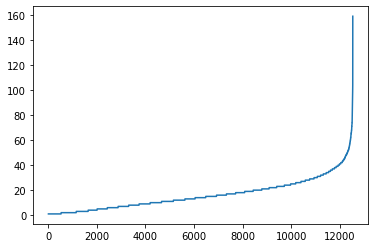

In [132]:
# test the ParserDataset class and plot sentence lengths
train_dataset = ParserDataset(train_data)
dev_dataset = ParserDataset(dev_data)
plt.plot(train_dataset.sent_lens)
plt.show()

# BERT parser

###Get subwords indices
Output from the bert tokenizer can split words that are not in the vocabulary. The following function gets indices for each token that indicate which actual word the token belongs to.

In [239]:
def get_word_level_indices(tok_sentence):
    indices = []
    subword_start, pad = 0, 0
    for i in range(len(tok_sentence)):
        if tok_sentence[i].startswith("##") and not tok_sentence[i-1].startswith("##"):
            start = i-pad-1
            pad += 1
            indices.append(start)
        elif(tok_sentence[i].startswith("##") and tok_sentence[i-1].startswith("##")):
            pad += 1
            indices.append(start)
        else:
            indices.append(i-pad)
    return indices

In [134]:
# example usage
tokens = ['the', 'quick', 'br', '##own', 'fox', 'jump', '##s']
print(get_word_level_indices(tokens))

[0, 1, 2, 2, 3, 4, 4]


###Batchifyer
The BertBatcher class tokenizes, adds padding and batches the dataset. Here, the labels are also converted into a matrix format that is used in the binary cross entropy loss function.

In [240]:
class BertBatcher():
    def __init__(self, device):
        self.device = device
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __call__(self, batch):
        
        labels = [label for sentence, label in batch]
        sentences = [sentence for sentence, label in batch]
        max_sentence_len = max([len(["[CLS]"] + self.tokenizer.tokenize(sentence) + ["[SEP]"]) for sentence in sentences])
        
        # create label matrix to be used in binary cross entropy
        new_labels = []
        for label in labels:
            label_mat = torch.zeros(max_sentence_len-1, max_sentence_len)
            for i, head in enumerate(label):
                label_mat[i, head] = 1.0
            new_labels.append(label_mat)

        # save word-level indices
        word_level_indices = []
        for sentence in sentences:
            sent_tokens = ["[CLS]"] + self.tokenizer.tokenize(sentence) + ["[SEP]"]
            sent_tokens_padded = sent_tokens + ["[PAD]"] * (max_sentence_len - len(sent_tokens))
            word_level_indices.append(get_word_level_indices(sent_tokens_padded))

        # tokenize all sentences in the batch and add padding
        processed_sentence = self.tokenizer(sentences, padding="max_length", return_tensors="pt", max_length=max_sentence_len)
        input_ids, attention_mask = itemgetter("input_ids", "attention_mask")(processed_sentence)

        return (input_ids.to(self.device), 
                attention_mask.to(self.device), 
                torch.stack(new_labels).to(self.device), 
                torch.tensor(word_level_indices).to((self.device)))

In [241]:
# test batcher and dataloader
train_dataset = ParserDataset(train_data, max_size=10)
dev_dataset = ParserDataset(dev_data, max_size=10)
bert_batcher = BertBatcher(device)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=bert_batcher)
test_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=32, collate_fn=bert_batcher)

for example in train_dataloader:
    input_ids, attention_mask, labels, word_level_indices = example
    break

In [142]:
# shapes for the output from the batcher
print(input_ids.shape)
print(attention_mask.shape)
print(labels.shape)
print(word_level_indices.shape)

torch.Size([10, 37])
torch.Size([10, 37])
torch.Size([10, 36, 37])
torch.Size([10, 37])


###Customized BERT model
The components in the final customized BERT model, including the biaffine attention layer and a function for doing word-level average pooling.

In [242]:
class Biaffine(nn.Module):
    def __init__(self, n_in, n_out=1, bias_x=True, bias_y=True):
        super(Biaffine, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.bias_x = bias_x
        self.bias_y = bias_y
        self.weight = nn.Parameter(torch.Tensor(n_out, n_in + bias_x, n_in + bias_y))
        self.reset_parameters()

    def reset_parameters(self):
        bound = 1 / math.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)

    def forward(self, x, y):
        if self.bias_x:
            x = torch.cat([x, x.new_ones(x.shape[:-1]).unsqueeze(-1)], -1)
        if self.bias_y:
            y = torch.cat([y, y.new_ones(y.shape[:-1]).unsqueeze(-1)], -1)
        # [batch_size, 1, seq_len, d]
        x = x.unsqueeze(1)
        # [batch_size, 1, seq_len, d]
        y = y.unsqueeze(1)
        # [batch_size, n_out, seq_len, seq_len]
        s = x @ self.weight @ y.transpose(-1, -2)
        # remove dim 1 if n_out == 1
        s = s.squeeze(1)

        return s

In [243]:
class CustomBERTModel(nn.Module):
    def __init__(self):
        super(CustomBERTModel, self).__init__()
        self.model = BertModel.from_pretrained("bert-base-uncased")
        self.biaffine = Biaffine(768) # 786 is the hidden dim in the BERT model
        self.dropout = torch.nn.Dropout(p=0.1)

    def word_level_pooling(self, last_hidden_state, word_level_indices):
        pooled_hidden = torch.zeros_like(last_hidden_state)
        for b in range(last_hidden_state.shape[0]):
            c = Counter(word_level_indices[b])
            padding = 0
            for idx in set(word_level_indices[b]):
                if c[idx] > 1:
                    padding += c[idx]-1
                    pooled_hidden[b][idx] = torch.mean(last_hidden_state[b][idx:idx+padding+1], dim=0)
                else:
                    pooled_hidden[b][idx] = last_hidden_state[b][idx+padding] 
        return pooled_hidden

    def forward(self, input_ids, attention_mask, word_level_indices):
        model_out  = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = model_out[0]

        # apply word-level pooling and dropout
        pooled_last_hidden = self.word_level_pooling(last_hidden_state, word_level_indices)
        pooled_last_hidden = self.dropout(pooled_last_hidden)

        X = pooled_last_hidden[:, 1:pooled_last_hidden.shape[1], :]
        X_prime = pooled_last_hidden[:, :pooled_last_hidden.shape[1], :]
        Y_arc = self.biaffine(X, X_prime)

        return Y_arc

In [ ]:
# test forward method
m = CustomBERTModel().to(device)
l = m.forward(input_ids[0:2], attention_mask[0:2], word_level_indices[0:2])

### Parser class
Class to instantiate, train and evaluate the parser.

In [245]:
class BertParser():

    def __init__(self):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.train_dataset = ParserDataset(train_data)
        self.dev_dataset = ParserDataset(dev_data)
        self.bert_batcher = BertBatcher(self.device)
        self.custom_bert = CustomBERTModel().to(self.device)

    def train(self, n_epochs=30, batch_size=8, lr=1e-5):
        
        train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size, collate_fn=self.bert_batcher)
        self.custom_bert.train()
        optimizer = torch.optim.AdamW(self.custom_bert.parameters(), lr=lr)
        info = {'epoch': 0, 'training_loss': 0, 'validation_UAS': 0} # training loss is per batch

        for epoch in range(n_epochs):
            info['epoch'] = epoch + 1
            with tqdm(total = len(train_loader)) as pbar:

                self.custom_bert.train()
                for input_ids, attention_mask, labels, word_level_indices in train_loader:

                    optimizer.zero_grad()
                    output = self.custom_bert.forward(input_ids, attention_mask, word_level_indices)                  

                    # get indices for where the padding starts
                    pad_indices = []
                    for i, j in enumerate(labels):
                        pad_indices.append(int(torch.sum(labels[i]).item()))

                    # create weights so that padding can be ignored in loss calculation
                    weights = torch.zeros_like(output).to(device)
                    for i, row in enumerate(weights):
                        row[:pad_indices[i], :pad_indices[i]+1] = 1

                    # calculate loss and backpropagate 
                    bce_loss = nn.BCEWithLogitsLoss(weight=weights)
                    loss = bce_loss(output, labels)
                    loss.backward()
                    optimizer.step()

                    info['training_loss'] = f'{loss.item():.6f}'
                    pbar.set_postfix(info)
                    pbar.update()
                
                # run evaluation on current epoch
                epoch_uas = self.evaluate()

                info['validation_UAS'] = f'{epoch_uas:.6f}'
                pbar.set_postfix(info)
                pbar.update()


    def evaluate(self, batch_size=8):

        dev_loader = torch.utils.data.DataLoader(self.dev_dataset, batch_size, collate_fn=self.bert_batcher)
        self.custom_bert.eval()

        accuracy, num_heads = 0, 0
        for input_ids, attention_mask, labels, word_level_indices in dev_loader:

            pad_indices = []
            for i, j in enumerate(labels):
                pad_indices.append(int(torch.sum(labels[i]).item()))

            with torch.no_grad():
                output = self.custom_bert.forward(input_ids, attention_mask, word_level_indices)

            for i, sentence in enumerate(output):
                predictions = torch.argmax(output[i, :pad_indices[i], :pad_indices[i]+1], dim=1)
                ys = torch.argmax(labels[i, :pad_indices[i], :pad_indices[i]], dim=1)
                accuracy += torch.sum(predictions == ys).item()
                num_heads += predictions.shape[0]

        return accuracy/num_heads

    def predict(self):
        pass

In [ ]:
parser = BertParser()

In [247]:
# train parser
parser.train(n_epochs=30, batch_size=8, lr=1e-5)

1569it [02:46,  9.40it/s, epoch=1, training_loss=0.021128, validation_UAS=0.290946]
1569it [02:46,  9.41it/s, epoch=2, training_loss=0.018716, validation_UAS=0.518152]
1569it [02:46,  9.42it/s, epoch=3, training_loss=0.017161, validation_UAS=0.604358]
1569it [02:47,  9.39it/s, epoch=4, training_loss=0.016326, validation_UAS=0.652233]
1569it [02:46,  9.40it/s, epoch=5, training_loss=0.015866, validation_UAS=0.683327]
1569it [02:46,  9.42it/s, epoch=6, training_loss=0.015625, validation_UAS=0.710326]
1569it [02:47,  9.39it/s, epoch=7, training_loss=0.014763, validation_UAS=0.728260]
1569it [02:46,  9.41it/s, epoch=8, training_loss=0.014254, validation_UAS=0.743847]
1569it [02:46,  9.41it/s, epoch=9, training_loss=0.013931, validation_UAS=0.754821]
1569it [02:46,  9.40it/s, epoch=10, training_loss=0.013660, validation_UAS=0.763569]
1569it [02:46,  9.41it/s, epoch=11, training_loss=0.013503, validation_UAS=0.767585]
1569it [02:46,  9.42it/s, epoch=12, training_loss=0.013518, validation_UAS

In [248]:
# do final evaluation on development data
parser.evaluate()

0.8248439301761501